In [244]:
from sklearn.datasets import fetch_lfw_people

lfw_dataset = fetch_lfw_people(min_faces_per_person=50, resize=0.4)
images = lfw_dataset.images  # Grayscale face images
labels = lfw_dataset.target  # Corresponding labels

Resize Images

In [245]:
import cv2
resized_images = [cv2.resize(img, (224, 224)) for img in images]


 Normalize Pixel Values

In [246]:
import numpy as np
normalized_images = np.array(resized_images) / 255.0


Encode Labels

In [247]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

Data Splitting

In [248]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    normalized_images, one_hot_labels, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [249]:
import numpy as np

# Add a channel dimension for grayscale images
X_train = np.expand_dims(X_train, axis=-1)  # Shape will become (num_samples, 224, 224, 1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


In [250]:
import numpy as np

# Convert grayscale to RGB
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # Repeats along the last axis
X_val_rgb = np.repeat(X_val, 3, axis=-1)      # Repeats along the last axis


In [266]:
import numpy as np

# Convert grayscale (1 channel) to RGB (3 channels)
X_test_rgb = np.repeat(X_test, 3, axis=-1)


Data augmentation

In [251]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_rgb)

In [252]:
print(X_train_rgb.shape)  # Should output (number_of_samples, 224, 224, 3)
print(X_val_rgb.shape)    # Should output (number_of_samples, 224, 224, 3)


(1092, 224, 224, 3)
(234, 224, 224, 3)


In [273]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modify the data generator to preprocess grayscale to RGB
datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = datagen.flow(
    np.repeat(X_test_rgb, 3, axis=-1),  # Convert grayscale to RGB
    y_test,
    batch_size=32,
    shuffle=False
)


c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (234, 224, 224, 9) (9 channels).
  warnings.warn(


Load a Pre-trained Model

In [253]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Add Custom Layers

In [254]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # To prevent overfitting
output = Dense(len(set(labels)), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

Freeze pre-trained layers

In [255]:
for layer in base_model.layers:
    layer.trainable = False

Compile the model

In [256]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model Summary

In [257]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,628 (68.39 MB)

 Trainable params: 3,212,940 (12.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Use a Data Generator for Augmentation

In [258]:
train_generator = datagen.flow(X_train_rgb, y_train, batch_size=32)


Train the Model

In [260]:
history = model.fit(
    train_generator,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    steps_per_epoch=len(X_train_rgb) // 32,
    validation_steps=len(X_val_rgb) // 32,
    verbose=1
)

c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.2071 - loss: 2.8295 - val_accuracy: 0.3846 - val_loss: 2.1363
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2188 - loss: 2.6425 
Epoch 3/20


c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


34/34 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3391 - loss: 2.3491 - val_accuracy: 0.3846 - val_loss: 2.2302
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.3750 - loss: 2.2846
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2994 - loss: 2.3492 - val_accuracy: 0.3846 - val_loss: 2.0733
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 527us/step - accuracy: 0.3438 - loss: 2.4110
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 356s 11s/step - accuracy: 0.3246 - loss: 2.3675 - val_accuracy: 0.3846 - val_loss: 2.1871
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 433us/step - accuracy: 0.5312 - loss: 2.0742
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.3343 - loss: 2.3504 - val_accuracy: 0.3846 - val_loss: 2.2140
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 546us/step - accuracy: 0.2500 - loss: 2.3770
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.3206 - loss: 2.3293 - val_accuracy: 0.3846 - val_loss: 2.2269
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━

 Plot Training and Validation Metrics

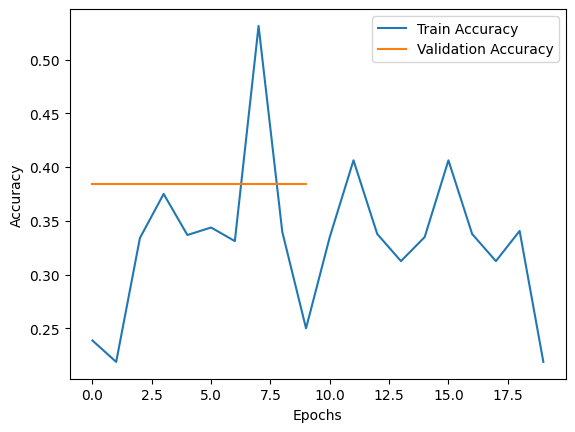

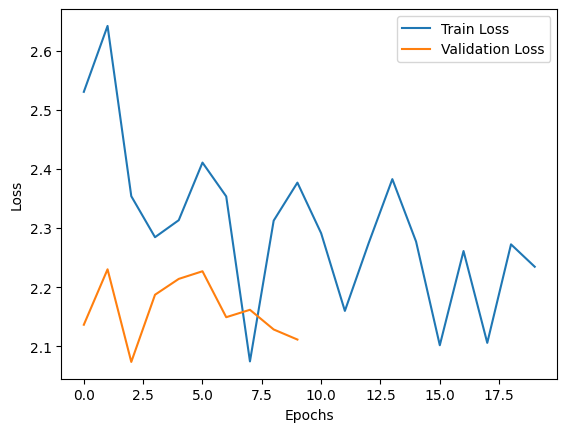

In [261]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [262]:
model.save('face_recognition_model.h5')

Prepare the test data

In [263]:
test_generator = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

Evaluate the Model on the Test Data

In [268]:
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.3299 - loss: 2.1792
Test Accuracy: 0.31
Test Loss: 2.20


Predict on Test Data

In [277]:
y_pred = model.predict(X_test_rgb)  # Or test_generator if using a generator
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1) 

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


Calculate Metrics

In [278]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00        21
           3       0.31      1.00      0.47        72
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00        14
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00        21

    accuracy                           0.31       234
   macro avg       0.03      0.08      0.04       234
weighted avg       0.09      0.31      0.14       234

Confusion Matrix:
[[ 0  0  0 12  0  0  0  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0  0  0  0  0]
 [ 0  0  0 21 

c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\richa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Visualize the Confusion Matrix

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=images, yticklabels=images)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'conf_matrix' is not defined

<Figure size 1000x800 with 0 Axes>

 Save Your Trained Model

In [1]:
model.save('face_recognition_model.h5')

NameError: name 'model' is not defined